In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense

In [34]:
data = pd.read_csv('airline-passengers.csv')
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
# normalize the data 
scalar = MinMaxScaler(feature_range=(0,1))
data_original = data.copy()
data.Passengers = scalar.fit_transform(data[['Passengers']])
data.head()

,Month,Passengers
0,1949-01,0.015444
1,1949-02,0.027027
2,1949-03,0.054054
3,1949-04,0.048263
4,1949-05,0.032819


prepare the data, sliding window approach: create input-output pairs: $(\bold{x_t}, y_t)$ for $t$ running from $L+1$ to $T$

It is often the case we have more than one features, for example, $v_{t}$, $r_{t}$, $z_{t}$ (see ISL 10.5.2). The input sequence $\bold{x_t} = \{{x_{t1}, x_{t2}, ..., x_{tL}}\}$ with a predefined length $L$. Each element in $\bold{x_t}$ is a 3-vector correpsonding to 3 measurements of the features, for example $x_{t1} = (v_{t-1}, r_{t-1}, z_{t-1})$, and $x_{tL} = (v_{t-L}, r_{t-L}, z_{t-L})$. RNN processes the sequence $\bold{x_t} = \{{x_{t1}, x_{t2}, ..., x_{tL}}\}$ from left to right.

Since $t$ is from $L+1$ to $T$ we have $T-L$ pairs $(\bold{x_t}, y_t)$; they are the samples.

In [36]:
def create_dataset(data, L=1):
    X, y = [], []
    for i in range(len(data)- L -1):
        X.append( data.iloc[i: (i+L), 1] )
        y.append( data.iloc[i + L, 1] )
    return np.array(X), np.array(y)

L = 2
X, y = create_dataset(data, 5)

np.column_stack([X,y])


array([[0.01544402, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
        0.05984556],
       [0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984556,
        0.08494208],
       [0.05405405, 0.04826255, 0.03281853, 0.05984556, 0.08494208,
        0.08494208],
       [0.04826255, 0.03281853, 0.05984556, 0.08494208, 0.08494208,
        0.06177606],
       [0.03281853, 0.05984556, 0.08494208, 0.08494208, 0.06177606,
        0.02895753],
       [0.05984556, 0.08494208, 0.08494208, 0.06177606, 0.02895753,
        0.        ],
       [0.08494208, 0.08494208, 0.06177606, 0.02895753, 0.        ,
        0.02702703],
       [0.08494208, 0.06177606, 0.02895753, 0.        , 0.02702703,
        0.02123552],
       [0.06177606, 0.02895753, 0.        , 0.02702703, 0.02123552,
        0.04247104],
       [0.02895753, 0.        , 0.02702703, 0.02123552, 0.04247104,
        0.07142857],
       [0.        , 0.02702703, 0.02123552, 0.04247104, 0.07142857,
        0.05984556],
       [0.02702703, 0

In [37]:
# reshape data for GRU
# GRU expects a 3-D input of the form [samples, the lag (L), features]
X = np.reshape(a=X, newshape=(X.shape[0], X.shape[1], 1))
X


array([[[0.01544402],
        [0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853]],

       [[0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984556]],

       [[0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984556],
        [0.08494208]],

       [[0.04826255],
        [0.03281853],
        [0.05984556],
        [0.08494208],
        [0.08494208]],

       [[0.03281853],
        [0.05984556],
        [0.08494208],
        [0.08494208],
        [0.06177606]],

       [[0.05984556],
        [0.08494208],
        [0.08494208],
        [0.06177606],
        [0.02895753]],

       [[0.08494208],
        [0.08494208],
        [0.06177606],
        [0.02895753],
        [0.        ]],

       [[0.08494208],
        [0.06177606],
        [0.02895753],
        [0.        ],
        [0.02702703]],

       [[0.06177606],
        [0.02895753],
        [0.        ],
        [0.02702703],
        [0.02123

In [38]:
# build a (stacked) GRU, 2 GRU layers followed by a dense output layer
model_gru_ts = Sequential([
    Input(shape=(L,1)),   # input layer, has L 1-vectors
    GRU(50, return_sequences= True),  # first GRU layer, has 50 units (hidden state size)
    GRU(50),  # second GRU layer, 50 units 
    Dense(1)  # has 1 unit, output a single scalar
    ])

# compile the model using Adam optimizer and the squared loss
model_gru_ts.compile(optimizer = 'adam', loss= 'mean_squared_error')


In [39]:
model_gru_ts.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 2, 50)          │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

Gradient descent usually takes many steps to reach a local minimum. In practice, there are a number of approaches for accelerating the process. Also, when n is large, instead of summing (10.29)–(10.30) over all n observations, we can sample a small fraction or *minibatch* of them each time minibatch we compute a gradient step. This process is known as *stochastic* gradient descent

Batch size: the number of samples the model sees before updating weights

Epoch: the number of times the model sees an equivalent of the full training set

In [40]:
# train the model for 100 epochs with a batch size of 32
model_gru_ts.fit(X, y, epochs = 100, batch_size = 32, verbose = 1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.1061
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0196
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0238
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0140
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0143
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0141
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0119
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0107
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0106
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0102
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0102
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0100
Epoch 16/100
5/5 ━

In [41]:
# make predictions
y_pred = model_gru_ts.predict(X)
y_pred = scalar.inverse_transform(y_pred)  # back-transform the normalized input values
y_actual = scalar.inverse_transform([y]).reshape(-1,1)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/stepWARNING:tensorflow:5 out of the last 21 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31920c400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


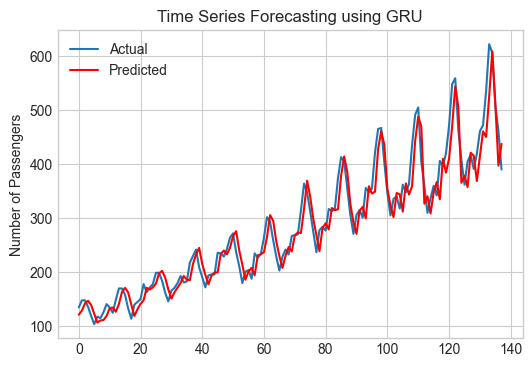

In [44]:
# Plot original data vs predictions
plt.figure(figsize=(6, 4))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted', color='r')
plt.ylabel('Number of Passengers')
plt.title('Time Series Forecasting using GRU')
plt.legend()
plt.show()